<a href="https://colab.research.google.com/github/brianhphillips/testrepo/blob/main/CatBoost_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khushikyad001/covid-19-reinfection-and-health-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid-19-reinfection-and-health-dataset


In [6]:
# Load dataset
csv_file = f"{path}/covid_related_disease_data.csv"
df = pd.read_csv(csv_file)

In [18]:
# Convert target variable to binary
X = df.drop(columns=["Reinfection", "Date_of_Reinfection"])
y = df["Reinfection"]

In [19]:
# Identify categorical features (object type, excluding target)
cat_features = df.select_dtypes(include=['object']).columns.tolist()
# The line below is removed because "Reinfection" is no longer an object type.
# cat_features.remove("Reinfection")

In [28]:
# Split data
y = df["Reinfection"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [29]:
# Build CatBoost Pool
# Fill NaN values in categorical features with a placeholder string
for col in cat_features:
    if col in X_train.columns: # Check if the column exists in X_train
        X_train[col] = X_train[col].fillna('Missing')
    if col in X_test.columns: # Check if the column exists in X_test
        X_test[col] = X_test[col].fillna('Missing')

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [30]:
# Train CatBoost model
model = CatBoostClassifier(verbose=100, eval_metric='AUC', random_state=42)
model.fit(train_pool)

Learning rate set to 0.014972
0:	total: 6.06ms	remaining: 6.05s
100:	total: 705ms	remaining: 6.27s
200:	total: 1.47s	remaining: 5.83s
300:	total: 2.31s	remaining: 5.37s
400:	total: 3.18s	remaining: 4.75s
500:	total: 4.13s	remaining: 4.11s
600:	total: 5.08s	remaining: 3.37s
700:	total: 6.59s	remaining: 2.81s
800:	total: 7.73s	remaining: 1.92s
900:	total: 8.75s	remaining: 962ms
999:	total: 9.73s	remaining: 0us


In [31]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       545
           1       1.00      1.00      1.00        55

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

AUC Score: 1.0


In [32]:
# --- Feature Importance Visualization ---
importances = model.get_feature_importance(train_pool)
feature_names = X.columns

In [33]:
# Create DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

<ipython-input-34-5914e31ac389>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')


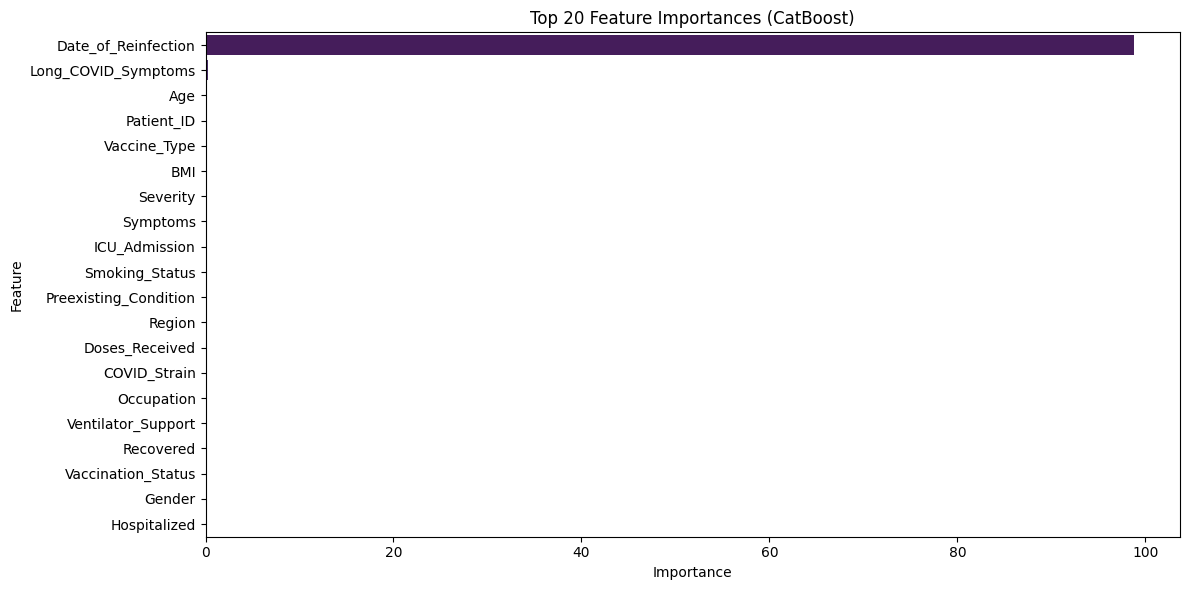

In [34]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importances (CatBoost)")
plt.tight_layout()
plt.show()